In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
import plotly.graph_objects as go
from IPython.display import HTML
plt.style.use('bmh')

## The Magnetic Field

We take into account a linearly increasing magnenic field along $e_z$, with an inward component of $e_r$ as follows:

$$ B(r) = -B_1 r e_r + (B_0 + B_1 z) e_z $$

$$ A = \frac{r}{2} (B_0 + B_1 z) e_\theta $$

Such a field can be generated near the axis of a tapered solenoid as presented in the schematic below:

<img src="solenoid.jpg" style="width: 50%">

Here's how it looks for $B_0 = 0.5\,mT$ and $B_1 = 1\,Tm^{-1}$:

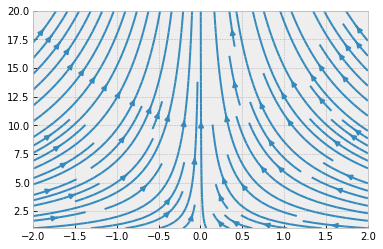

In [7]:
B0 = 0.5e-3
B1 = 1
x = np.linspace(-2, 2, 5)
y = np.linspace(-2, 2, 5)
z = np.linspace(1, 20, 5)
xs, zs = np.meshgrid(x, z)
xv, yv, zv = np.meshgrid(x, y, z)
Bx = -B1*xv
By = -B1*yv
Bz = B0 + B1*zv

plt.streamplot(xs, zs, -B1*xs, B0+B1*zs)

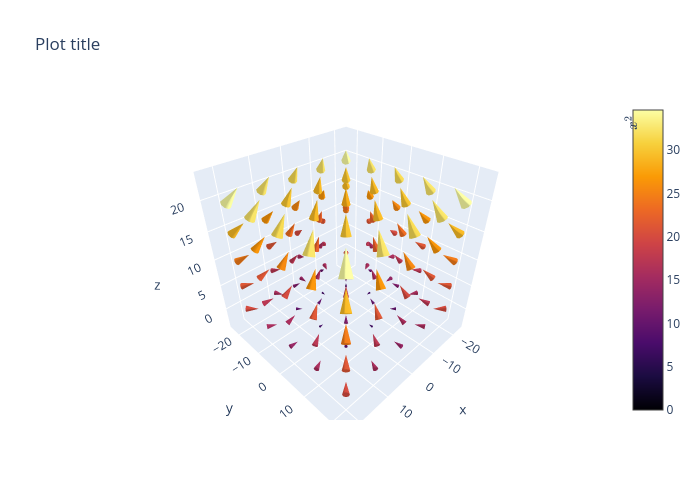

In [3]:
data = go.Cone(
    x=xv.ravel(), y=yv.ravel(), z=zv.ravel(),
    u=Bx.ravel(), v=By.ravel(), w=Bz.ravel(),
    colorscale='Inferno', colorbar=dict(title='$x^2$'),
    sizemode="absolute", sizeref=20
)

layout = go.Layout(
    title=r'Magnetic Field',
    scene=dict(
        xaxis_title = r'x',
        yaxis_title = r'y',
        zaxis_title = r'z',
        aspectratio = dict(x=1, y=1, z=1),
        camera_eye = dict(x=1.2, y=1.2, z=1.2)
    )
)

fig = go.Figure(data = data, layout = layout)
fig.show()

## The Schrodinger Equation

\begin{align*}
\hat{H} &= \frac{(\hat{p} + eA^2)}{2m} + \mu_B\, B\cdot\sigma\\
&= \frac{-\hbar^2}{2m}\nabla^2 + \mu_B(B_z \sigma_z)
\end{align*}

We ignored terms containing $B^2$, as one can easily argue that these terms are far too small for achievable magnetic fields ($B<10^5\; Gauss$) in laboratories. We also neglect $B_r\sigma_r$ as $B_0$ is much stronger than $B_1r$ for our charge distribution.

The Time Dependent Schrodinger Equation is

$$
i\hbar \frac{\partial }{\partial t} \psi(r, z, t) = -\frac{\hbar^2}{2m}\left( \frac{\partial ^2}{\partial r^2} + \frac{1}{r}\frac{\partial }{\partial r} + \frac{\partial ^2}{\partial z^2}  \right)\psi(r, z, t) + \mu_B(B_0 + B_1 z)\psi(r, z, t)
$$

We don't need to deal with extra parameters like $m$, $\hbar$, etc. Multiplying both sides by $\frac{2mL^2}{\hbar^2}$ where $L$ is the characteristic length of the problem (here electrons are traveling a length $L$)

$$
i \frac{2mL^2}{\hbar} \frac{\partial }{\partial t} \psi = -L^2 \left( \frac{\partial ^2}{\partial r^2} + \frac{1}{r}\frac{\partial }{\partial r} + \frac{\partial ^2}{\partial z^2}  \right)\psi + \left( \frac{2mL^2\mu_B B_0}{\hbar^2} + \frac{2mL^2\mu_B B_1}{\hbar^2} \frac{L}{L} z \right)\sigma_z
$$


Now make the transformations
* $ r' = \frac{r}{L}$
* $ z' = \frac{z}{L}$
* $ t' = \frac{\hbar}{2mL^2} $
* $ b_0 = \frac{2mL^2\mu_BB_0}{\hbar^2} $
* $ b_1 = \frac{2mL^3\mu_BB_1}{\hbar^2} $
* $\sigma_z \rightarrow s = \pm1$

One can check that all of the quantities above are dimensionless. The Schrodinger equation with respect to these variables becomes

$$
i \frac{\partial }{\partial t'}\psi = - \left( \frac{\partial ^2}{\partial r'^2} + \frac{1}{r'}\frac{\partial }{\partial r'} + \frac{\partial ^2}{\partial z'^2}  \right)\psi + s(b_0 + b_1z')\psi
$$

We solve this equation for $r'$, $z'$ and $t'$ and then solve for $r$, $z$ and $t$ using

* $r = Lr'$
* $z = Lz'$
* $t = \frac{\hbar}{2mL^2}t'$

**For all the numerical work we will drop the primes on $r'$, $z'$, and $t'$ but know \hat{t} we are working with the primed quantities.**


## Finite Difference Approximation

Choose a discrete grid with spacing $\Delta r$ and $\Delta z$ and $\Delta t$ and let $\psi_{i, n}^{m} = \psi(i\Delta r, n\Delta z, m\Delta t)$

$$
i \frac{\psi_{i,n}^{m+1} - \psi_{i, n}^m}{\Delta t} = - \frac{\psi_{i+1, n}^m - 2\psi_{i, n}^m + \psi_{i-1, n}^m}{\Delta r^2} -\frac{1}{r}\frac{\psi_{i+1, n}^m - \psi_{i, n}^m}{\Delta r} -\frac{\psi_{i, n+1}^m - 2\psi_{i, n}^m + \psi_{i, n-1}^m}{\Delta z^2} + s(b_0 + b_1 z) \psi_{i, n}^m
$$

Rearrange the equation

$$
\psi_{i,n}^{m+1} = \psi_{i,n}^m + \frac{i}{2}\Delta t\left(\frac{\psi_{i+1, n}^m - 2\psi_{i, n}^m + \psi_{i-1, n}^m}{\Delta r^2} + \frac{1}{r}\frac{\psi_{i+1, n}^m - \psi_{i, n}^m}{\Delta r} + \frac{\psi_{i, n+1}^m - 2\psi_{i, n}^m + \psi_{i, n-1}^m}{\Delta z^2} \right) - i\Delta t s(b_0 + b_1 z) \psi_{i, n}^m
$$




Define all parameters of interest.

In [22]:
Nr = 21
Nz = 61
Nt = 3600000
times_snapshot = 3600
f = int(Nt/times_snapshot)
dr = 1/(Nr-1)
dz = 1/(Nz-1)
dt = 1e-7
z = np.linspace(-4, 4, Nz)
r = np.linspace(0, 0.03, Nr)
b0 = 50
b1 = 10
Z, R = np.meshgrid(z, r)
psi0 = np.exp(-R**2/(4*(0.005**2))) * np.exp(-Z**2/4)

The initial condition here is

$$ \psi(r, z, 0) = e^{{-r^2}/{4\delta_r^2}}\;e^{{-z^2}/{4\delta_z^2}} $$

In [23]:
psi = np.zeros([times_snapshot, Nr, Nz])
psi[0] = psi0

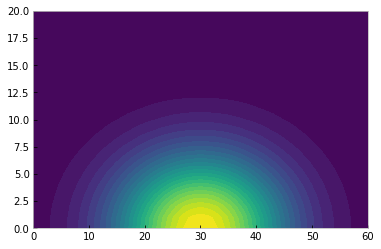

In [32]:
plt.contourf(psi0, 30)
plt.grid()

In [28]:
@numba.jit("c16[:, :, :](c16[:, :, :], f8)", nopython=True, nogil=True)
def compute_psi(psi, s):
  cs = psi[0].copy()  # current state
  len_z = len(cs[0])
  len_r = len(cs[:, 0])
  cf = 0  # current frame
  for t in range(1, Nt):
    ns = cs.copy()  # new state
    for i in range(1, len_r-1):
      for n in range(1, len_z-1):
        ns[i][n] = cs[i][n] + 1j/2 * dt * ((cs[i+1][n] - 2*cs[i][n] + cs[i-1][n])/dr**2 + (cs[i+1][n] - cs[i][n])/(2*r[i]*dr) + (cs[i][n+1] - 2*cs[i][n] + cs[i][n-1])/dz**2) - 1j*dt*s*(b0 + b1*z[n])*cs[i][n]

    normal = np.sum(np.absolute(ns)**2)*dr*dz
    for i in range(1, Nr-1):
      for n in range(1, Nz-1):
        ns[i][n] = ns[i][n] / normal
    
    cs = ns.copy()
    if t%f==0:
      cf = cf + 1
      psi[cf] = cs
    
  return psi

In [29]:
psi_p = compute_psi(psi.astype(complex), 1)
psi_n = compute_psi(psi.astype(complex), -1)

In [38]:
psi = (np.absolute(psi_n)**2  + np.absolute(psi_p)**2)/2  # average to account for spin superposition

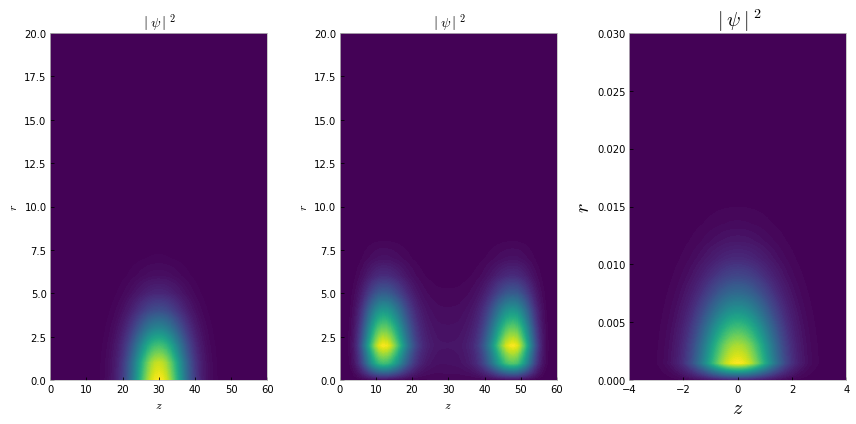

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
ax = axes[0]
ax.contourf(np.absolute(psi[0])**2, 100)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$r$')
ax.set_title(r'$\mid\psi\mid^2$')
ax.grid()

ax = axes[1]
ax.contourf(np.absolute(psi[1000])**2, 100)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$r$')
ax.set_title(r'$\mid\psi\mid^2$')
ax.grid()

ax = axes[2]
cs = ax.contourf(Z, R, psi[1], 100)
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$r$', fontsize=20)
ax.set_title(r'$\mid\psi\mid^2$', fontsize=20)
ax.grid()

plt.tight_layout()
plt.show()

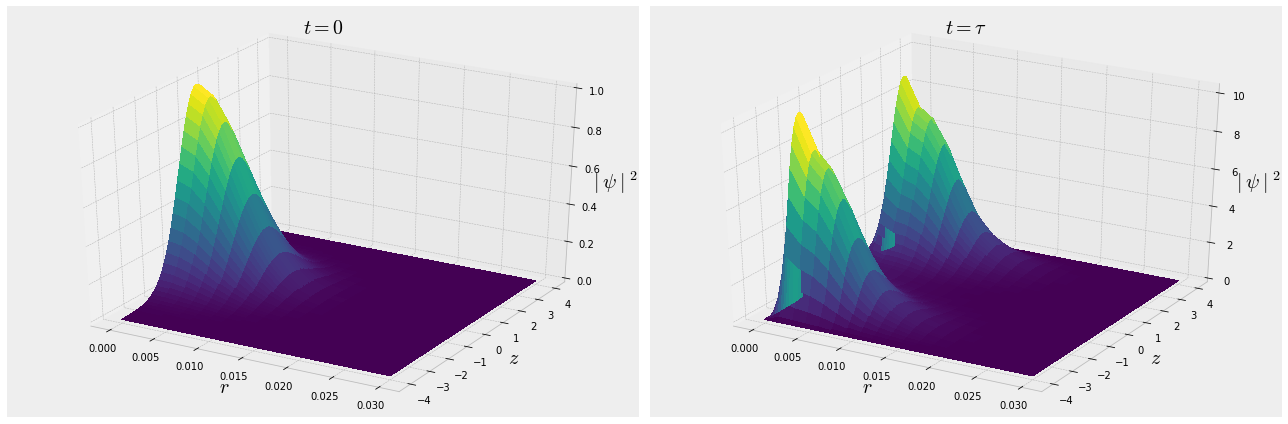

In [89]:
# 3D Plot
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 2, 1, projection='3d', elev=30)
t = 0
ax.plot_surface(R, Z, psi[t], cmap='viridis', rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_xlabel('$r$', fontsize=20)
ax.set_ylabel('$z$', fontsize=20)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r'$\mid \psi\mid ^2$', fontsize=20, rotation=0)
ax.set_title(f'$t={t}$', fontsize=20)

ax = fig.add_subplot(1, 2, 2, projection='3d', elev=30)
t = 3599
ax.plot_surface(R, Z, psi[t], cmap='viridis', rstride=1, cstride=1, linewidth=0, antialiased=False)
ax.set_xlabel('$r$', fontsize=20)
ax.set_ylabel('$z$', fontsize=20)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r'$\mid \psi\mid ^2$', fontsize=20, rotation=0)
ax.set_title(r'$t=\tau$', fontsize=20)

fig.tight_layout()

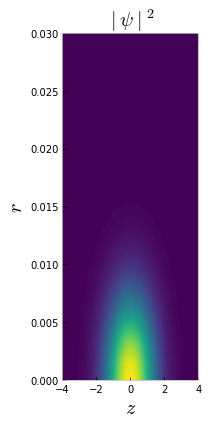

In [94]:
# 2D Animation

fig, ax = plt.subplots(1, 1, figsize=(3, 6))
#for ax in axes:

def animate(i):
  ax.clear()
#  axes[1].clear()
#  axes[0].contourf(np.absolute(psi_n[10*i])**2, 100)
  ax.contourf(Z, R, psi[10*i], 100)
  ax.set_xlabel(r'$z$', fontsize=20)
  ax.set_ylabel(r'$r$', fontsize=20)
  ax.set_title(r'$\mid\psi\mid^2$', fontsize=20)
  ax.grid()
  plt.tight_layout()

ani = animation.FuncAnimation(fig, animate, frames=359, interval=50)
ani.save('ani.gif', writer='pillow', fps=30)

In [ ]:
# 3D Animation
fig = plt.figure(figsize=(9,6))
ax = Axes3D(fig, elev=60)

ax.set_xlabel('$r$', fontsize=20)
ax.set_ylabel('$z$', fontsize=20)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel(r'$\mid \psi\mid ^2$', fontsize=20, rotation=0)

def animate(i):
  ax.clear()
  ax.plot_surface(R, Z, psi[10*i], cmap='viridis')

ani = animation.FuncAnimation(fig, animate, frames=359, interval=50)
ani.save('3dani.gif', writer='pillow', fps=30)